In [18]:
import os
import sys
import pandas as pd
import geopandas as gpd
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    precision_score,
    recall_score,
    precision_recall_curve,
    ConfusionMatrixDisplay,
    roc_curve,
    RocCurveDisplay,
    auc,
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
)
from sklearn.model_selection import RandomizedSearchCV, train_test_split

from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV

from scipy.stats import randint
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
import matplotlib.pyplot as plt

from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz

sys.path.append("../utils")


In [19]:
data = pd.read_csv(
    "/capstone/wildfire_prep/data/PUZZLE_PIECES/assembled_puzzle.csv"
).drop(columns="basemap_id")

In [20]:
print(data.shape)
print(data.columns)
data.head()

(67580, 4005)
Index(['inspection_id', 'X_0', 'X_1', 'X_2', 'X_3', 'X_4', 'X_5', 'X_6', 'X_7',
       'X_8',
       ...
       'X_3994', 'X_3995', 'X_3996', 'X_3997', 'X_3998', 'X_3999',
       'maj_landcover_code_x', 'maj_landcover_code_y', 'status',
       'structure_code'],
      dtype='object', length=4005)


,inspection_id,X_0,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,...,X_3994,X_3995,X_3996,X_3997,X_3998,X_3999,maj_landcover_code_x,maj_landcover_code_y,status,structure_code
0,1,0.054892,0.0,0.015004,0.0,0.238797,0.000466,0.0,0.055266,0.005605,...,0.052267,2.742807,1.274291,1.905394,4.261047,2.500061,304.0,557,0,100
1,2,0.024470,0.0,0.003108,0.0,0.129467,0.000687,0.0,0.034108,0.012225,...,0.232065,2.272318,1.205103,1.661454,3.457836,2.098205,304.0,304,0,101
2,3,0.271383,0.0,0.126712,0.0,0.976787,0.043854,0.0,0.528058,0.124882,...,0.000000,3.815154,1.246298,2.504779,6.486201,3.454411,303.0,303,0,101
3,4,0.097084,0.0,0.037654,0.0,0.549639,0.001046,0.0,0.240636,0.017580,...,0.016924,3.105121,1.228030,2.112541,5.209030,2.868551,39.0,304,0,100
4,5,0.041986,0.0,0.008531,0.0,0.253195,0.001353,0.0,0.036694,0.002605,...,0.040597,2.683573,1.311833,1.853227,4.251881,2.500635,304.0,304,0,101


## Downsample Majority Class Approach


In [21]:
X = data.drop("status", axis=1)
y = data["status"]

upsample_data_ids = X.inspection_id

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

train = pd.concat([X_train, y_train], axis=1)

majority = train[train.status == 0]
minority = train[train.status == 1]

n_majority_desired = len(minority) * 3
majority_downsampled = majority.sample(
    n=n_majority_desired, replace=False, random_state=42
)

train_balanced = (
    pd.concat([majority_downsampled, minority])
    .sample(frac=1, random_state=42)
    .reset_index(drop=True)
)

X_train = train_balanced.drop("status", axis=1).drop(columns="inspection_id")
y_train = train_balanced["status"]

X_test = X_test.drop(columns="inspection_id")

print(f"Shape of compliant:", compliant.shape)
print(f"Shape of non-compliant:", non_compliant.shape)

print(f"N_minority desired:", int(len(compliant) * 3))

print("Shapes:")
print(" Downsampled X_train:", X_train.shape)
print(" Downsampled y_train:", y_train.shape)
print(" Downsampled X_test: ", X_test.shape)
print(" Downsampled y_test: ", y_test.shape)

print("\nTrain distribution after up-sampling:")
print(y_train.value_counts(normalize=True))

X_train


Shape of compliant: (67162, 4005)
Shape of non-compliant: (418, 4005)
N_minority desired: 201486
Shapes:
 Downsampled X_train: (1336, 4003)
 Downsampled y_train: (1336,)
 Downsampled X_test:  (13516, 4003)
 Downsampled y_test:  (13516,)

Train distribution after up-sampling:
status
0    0.75
1    0.25
Name: proportion, dtype: float64


,X_0,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,...,X_3993,X_3994,X_3995,X_3996,X_3997,X_3998,X_3999,maj_landcover_code_x,maj_landcover_code_y,structure_code
0,0.980615,0.0,0.498733,0.001490,1.925463,0.219529,0.0,0.982447,0.366697,0.063637,...,1.917105,0.009606,5.100002,1.500538,3.119550,8.773360,4.585543,303.0,582,102
1,0.595608,0.0,0.368074,0.017719,1.460289,0.205838,0.0,0.779316,0.339393,0.055420,...,1.927565,0.051871,4.595747,1.406411,2.920641,7.778569,4.184819,581.0,304,102
2,0.166876,0.0,0.098818,0.000000,0.838690,0.024531,0.0,0.378152,0.045195,0.000267,...,1.666842,0.000407,3.668862,1.303262,2.445058,6.129449,3.333632,303.0,582,102
3,0.251729,0.0,0.217023,0.000000,0.943251,0.136851,0.0,0.667194,0.302191,0.008528,...,1.847715,0.039587,3.930247,1.121837,2.670616,6.626384,3.462433,556.0,556,101
4,0.517334,0.0,0.193630,0.000000,1.533866,0.117757,0.0,0.760257,0.226459,0.012133,...,1.995993,0.000000,4.638525,1.332656,2.960548,7.932229,4.292342,582.0,582,102
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1331,0.214842,0.0,0.084297,0.003410,0.632061,0.075151,0.0,0.250915,0.165691,0.036268,...,1.610542,0.224676,3.254421,1.229582,2.219869,5.227838,3.010955,581.0,304,102
1332,0.659951,0.0,0.438005,0.000000,1.623533,0.192162,0.0,0.806604,0.205872,0.074531,...,1.821152,0.000802,4.668066,1.557677,2.876851,8.065570,4.291951,581.0,303,100
1333,0.346324,0.0,0.281637,0.000000,1.226964,0.136658,0.0,0.847138,0.388027,0.016122,...,1.910953,0.000000,4.322846,1.148208,2.836028,7.401264,3.821792,556.0,581,104
1334,0.870053,0.0,0.559589,0.002623,2.033172,0.348026,0.0,1.069538,0.424388,0.119261,...,2.059601,0.002596,5.287234,1.534886,3.268098,9.213343,4.864600,582.0,303,102


## Upsample Minority Class Approach


In [22]:
X = data.drop("status", axis=1)
y = data["status"]

# Save inspection_ids from the data, in case we need them later
upsample_data_ids = X.inspection_id

# split data, as usual. 20% test data split.
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Recombine just the train fold
train = pd.concat([X_train, y_train], axis=1)

# Up-sample the minority inside train
majority = train[train.status == 0]
minority = train[train.status == 1]
n_min = int(len(majority) / 3)

minority_upsampled = minority.sample(n=n_min, replace=True, random_state=42)

train_balanced = (
    pd.concat([majority, minority_upsampled])
    .sample(frac=1, random_state=42)
    .reset_index(drop=True)
)

X_train = train_balanced.drop("status", axis=1).drop(columns="inspection_id")
y_train = train_balanced["status"]
X_test = X_test.drop(columns="inspection_id")

# Check majority/minority sizes
print(f"Shape of compliant:", compliant.shape)
print(f"Shape of non-compliant:", non_compliant.shape)

print(f"N_minority desired:", int(len(compliant) / 3))

print("Shapes:")
print(" Upsampled X_train:", X_train.shape)
print(" Upsampled y_train:", y_train.shape)
print(" Upsampled X_test: ", X_test.shape)
print(" Upsampled y_test: ", y_test.shape)

print("\nTrain distribution after up-sampling:")
print(y_train.value_counts(normalize=True))

X_train


Shape of compliant: (67162, 4005)
Shape of non-compliant: (418, 4005)
N_minority desired: 22387
Shapes:
 Upsampled X_train: (71640, 4003)
 Upsampled y_train: (71640,)
 Upsampled X_test:  (13516, 4003)
 Upsampled y_test:  (13516,)

Train distribution after up-sampling:
status
0    0.75
1    0.25
Name: proportion, dtype: float64


,X_0,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,...,X_3993,X_3994,X_3995,X_3996,X_3997,X_3998,X_3999,maj_landcover_code_x,maj_landcover_code_y,structure_code
0,0.331932,0.0,0.155317,0.001381,1.019321,0.149126,0.0,0.463005,0.184660,0.054773,...,1.747563,0.052011,3.854411,1.336933,2.510178,6.464772,3.571856,581.0,581,102
1,0.041893,0.0,0.045376,0.000000,0.226781,0.028766,0.0,0.099595,0.104055,0.011859,...,1.436027,0.250101,2.553550,1.153797,1.876783,3.903363,2.304808,583.0,582,102
2,0.487315,0.0,0.205840,0.000000,1.428233,0.080608,0.0,0.678452,0.113209,0.004575,...,1.885410,0.000000,4.448287,1.389064,2.812428,7.569997,4.098632,39.0,581,100
3,0.617308,0.0,0.403863,0.000000,1.630068,0.150945,0.0,0.863991,0.176445,0.001145,...,1.884115,0.000000,4.713657,1.480072,2.952140,8.134626,4.289285,304.0,303,101
4,0.337975,0.0,0.204831,0.000245,1.043153,0.131792,0.0,0.528441,0.154996,0.036168,...,1.704785,0.055519,3.850144,1.299550,2.506843,6.557403,3.541020,581.0,556,107
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71635,0.727093,0.0,0.370492,0.002025,1.537865,0.197491,0.0,0.691560,0.267884,0.081505,...,1.754412,0.015851,4.478741,1.513182,2.763578,7.669852,4.114849,581.0,557,106
71636,0.924879,0.0,0.499406,0.001395,1.933097,0.196872,0.0,0.884723,0.278062,0.062329,...,1.893161,0.004936,5.073311,1.639850,3.075902,8.721411,4.650027,581.0,556,102
71637,0.480514,0.0,0.291867,0.002268,1.447743,0.270847,0.0,0.803332,0.348975,0.106511,...,1.997765,0.009894,4.538110,1.288358,2.952441,7.846379,4.204723,581.0,303,102
71638,0.530461,0.0,0.304156,0.014298,1.248092,0.223953,0.0,0.601414,0.324865,0.148117,...,1.799236,0.116030,4.151845,1.366152,2.641078,7.023295,3.874680,581.0,581,102


In [23]:
# # Outdated upsample cell

# # Pull out majority/minority from data
# compliant = data[data.status == 0]
# non_compliant = data[data.status == 1]

# # Upsample minority to match majority’s size
# n_minority_desired = int(len(compliant) / 3)

# non_compliant_upsampled = non_compliant.sample(
#     n=n_minority_desired, replace=True, random_state=42
# )

# # Reassemble and shuffle train set
# data_upsampled_min = (
#     pd.concat([compliant, non_compliant_upsampled])
#     .sample(frac=1, random_state=42)
#     .reset_index(drop=True)
# )

# # Split back into X_train y_train, upsampled
# X = data_upsampled_min.drop("status", axis=1)
# y = data_upsampled_min["status"]

# # Save inspection_ids from the data, in case we need them later
# upsample_data_ids = X.inspection_id

# # split data, as usual. 20% test data split.
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=0.2, stratify=y, random_state=42
# )

# # Dropping inspection_id, to prevent overfitting to this ID.
# X_train = X_train.drop(columns="inspection_id")
# # Do the same for X_test, so that the datasets align
# X_test = X_test.drop(columns="inspection_id")

# # Check majority/minority sizes
# print(f"Shape of compliant:", compliant.shape)
# print(f"Shape of non-compliant:", non_compliant.shape)

# print(f"N_minority desired:", int(len(compliant) / 3))
# print(f"Shape of non-compliant upsampled:", non_compliant_upsampled.shape)
# print(f"Shape of upsampled training data:", data_upsampled_min.shape)

# print("Shapes:")
# print(" Upsampled X_train:", X_train.shape)
# print(" Upsampled y_train:", y_train.shape)
# print(" Upsampled X_test: ", X_test.shape)
# print(" Upsampled y_test: ", y_test.shape)

# print("\nTrain distribution after up-sampling:")
# print(y_train.value_counts(normalize=True))

# X_train

In [24]:
# Make code chunk to do both upsampling and downsampling:
# Downsample majority and then upsample minority, all in the same data

## Random Forest Classifier Model


In [25]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Length of y_pred:", len(y_pred))
print("Accuracy:", accuracy)


Length of y_pred: 13516
Accuracy: 0.99363717076058


In [26]:
param_dist = {
    "max_depth": randint(1, 20),
    "min_samples_leaf": [1, 5, 10, 20],
    "max_features": ["sqrt", "log2", 0.2, 0.5],
    # "class_weight": [None, "balanced", "balanced_subsample"],
}

rf = RandomForestClassifier(random_state=42, n_jobs=-1, bootstrap=True)

halving_search = HalvingRandomSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    resource="n_estimators",
    min_resources=20,
    max_resources=200,
    factor=3,
    cv=2,
    scoring="precision",
    n_jobs=1,
    verbose=1,
)

halving_search.fit(X_train, y_train)

best_rf = halving_search.best_estimator_


n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 20
max_resources_: 200
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 10
n_resources: 20
Fitting 2 folds for each of 10 candidates, totalling 20 fits


/Users/ryangreen/.conda/envs/prg/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ryangreen/.conda/envs/prg/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ryangreen/.conda/envs/prg/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/

----------
iter: 1
n_candidates: 4
n_resources: 60
Fitting 2 folds for each of 4 candidates, totalling 8 fits
----------
iter: 2
n_candidates: 2
n_resources: 180
Fitting 2 folds for each of 2 candidates, totalling 4 fits


In [27]:
best_params = halving_search.best_params_

best_rf = RandomForestClassifier(
    **best_params,
    random_state=42,
    n_jobs=-1,
    bootstrap=True
)

best_rf.fit(X_train, y_train)

y_pred = best_rf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Length of y_pred:", len(y_pred))
print("Accuracy:", accuracy)

y_scores = best_rf.predict_proba(X_test)[:, 1]

print(best_params)


Length of y_pred: 13516
Accuracy: 0.9937111571470849
{'max_depth': 15, 'max_features': 0.2, 'min_samples_leaf': 5, 'n_estimators': 180}


In [28]:
# # RandomizedSeacrchCV cell
# param_dist = {
#     "n_estimators": randint(50, 500),
#     "max_depth": randint(1, 20),
#     "class_weight": [None, "balanced", "balanced_subsample"],
# }

# param_dist.update(
#     {
#         "min_samples_leaf": [1, 5, 10, 20],
#         "max_features": ["sqrt", "log2", 0.2, 0.5],
#     }
# )

# rf = RandomForestClassifier(
#     random_state=42,
#     n_jobs=-1,
#     # ,
#     # max_samples = 0.7,    # added
#     # bootstrap = True      # added
# )
# # random search method
# rand_search = RandomizedSearchCV(
#     rf,
#     param_distributions = param_dist,
#     n_iter = 20,      # increased from 10, originally 20
#     cv = 3,           # increased from 2, originally 3
#     scoring = "precision",
#     #scoring = 'recall',
#     refit = True,
#     n_jobs = 1,
#     verbose = 1,
# )
# rand_search.fit(X_train, y_train)

# best_rf = rand_search.best_estimator_

# y_scores = best_rf.predict_proba(X_test)[:, 1]


In [29]:
# TESTING PRECISION
# greatest precision achievable is 0.5, default


# 6 Quick diagnostic of your score distribution
print("Probability range:", y_scores.min(), "to", y_scores.max())
print("Positives at 0.5 cutoff:", (y_scores >= 0.5).sum())

# 7 Try a few fixed thresholds
for thresh in np.arange(0.50, 0.65, 0.01):
    preds = (y_scores >= thresh).astype(int)
    print(f"\nThreshold {thresh:.001f} → Positives = {preds.sum()}")
    print(" Precision:", precision_score(y_test, preds))
    print(" Recall:   ", recall_score(y_test, preds))

# 8 Precision–Recall curve based threshold search
precisions, recalls, thresholds = precision_recall_curve(y_test, y_scores)
precisions = precisions[:-1]  # align lengths with thresholds

# What’s the best precision you can actually hit?
best_possible_precision = precisions.max()
print("\nBest achievable precision:", best_possible_precision)

# Now find the first threshold that reaches ≥0.6, if any
target = 0.6
valid = np.where(precisions >= target)[0]

if valid.size:
    best_idx = valid[0]
    best_thresh = thresholds[best_idx]
    print(f"Threshold for ≥{target:.2f} precision:", best_thresh)
    y_pred_opt = (y_scores >= best_thresh).astype(int)
    print(" Precision:", precision_score(y_test, y_pred_opt))
    print(" Recall:   ", recall_score(y_test, y_pred_opt))
else:
    print(
        f"No threshold yields ≥{target:.2f} precision. "
        f"Falling back to best achievable precision of "
        f"{best_possible_precision:.3f}."
    )
    # you could pick the threshold for that best precision:
    best_idx = np.argmax(precisions)
    best_thresh = thresholds[best_idx]
    print("  Using threshold:", best_thresh)
    y_pred_opt = (y_scores >= best_thresh).astype(int)
    print("  Precision:", precision_score(y_test, y_pred_opt))
    print("  Recall:   ", recall_score(y_test, y_pred_opt))

Probability range: 0.0 to 0.9471290824670616
Positives at 0.5 cutoff: 1

Threshold 0.5 → Positives = 1
 Precision: 0.0
 Recall:    0.0

Threshold 0.5 → Positives = 1
 Precision: 0.0
 Recall:    0.0

Threshold 0.5 → Positives = 1
 Precision: 0.0
 Recall:    0.0

Threshold 0.5 → Positives = 1
 Precision: 0.0
 Recall:    0.0

Threshold 0.5 → Positives = 1
 Precision: 0.0
 Recall:    0.0

Threshold 0.6 → Positives = 1
 Precision: 0.0
 Recall:    0.0

Threshold 0.6 → Positives = 1
 Precision: 0.0
 Recall:    0.0

Threshold 0.6 → Positives = 1
 Precision: 0.0
 Recall:    0.0

Threshold 0.6 → Positives = 1
 Precision: 0.0
 Recall:    0.0

Threshold 0.6 → Positives = 1
 Precision: 0.0
 Recall:    0.0

Threshold 0.6 → Positives = 1
 Precision: 0.0
 Recall:    0.0

Threshold 0.6 → Positives = 1
 Precision: 0.0
 Recall:    0.0

Threshold 0.6 → Positives = 1
 Precision: 0.0
 Recall:    0.0

Threshold 0.6 → Positives = 1
 Precision: 0.0
 Recall:    0.0

Threshold 0.6 → Positives = 1
 Precision: 0.0

Accuracy: 0.9937111571470849
Precision: 0.0
Recall: 0.0


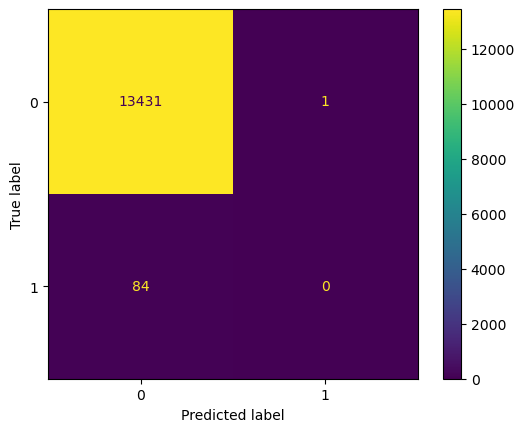

In [31]:
feature_importances = pd.Series(
    best_rf.feature_importances_, index=X_train.columns
).sort_values(ascending=False)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(confusion_matrix=cm).plot();


In [32]:
# X_test["mismatch"] = X_test["status"] != X_data["predicted_status"]

# num_mismatch = X_test["mismatch"].sum()
# pct_mismatch = X_test["mismatch"].mean()

# print(f"Total mismatches: {num_mismatch}")
# print(f"Error rate:     {pct_mismatch:.2%}")


In [33]:
# Testing new Thresholds Chunk
# precisions, recalls, thresholds = precision_recall_curve(y_test, y_scores)

# new_thresh = 0.59
# y_pred_adj = (y_scores >= new_thresh).astype(int)
# print(classification_report(y_test, y_pred_adj))

# cm = confusion_matrix(y_test, y_pred_adj)


# plt.plot(thresholds, precisions[:-1], label="Precision")
# plt.plot(thresholds, recalls[:-1], label="Recall")
# plt.xlabel("Threshold")
# plt.legend()
# plt.show()


# ConfusionMatrixDisplay(confusion_matrix=cm).plot()


Feature importances:
 maj_landcover_code_y    0.040011
structure_code          0.006373
maj_landcover_code_x    0.005969
X_3007                  0.004881
X_1387                  0.003665
dtype: float64


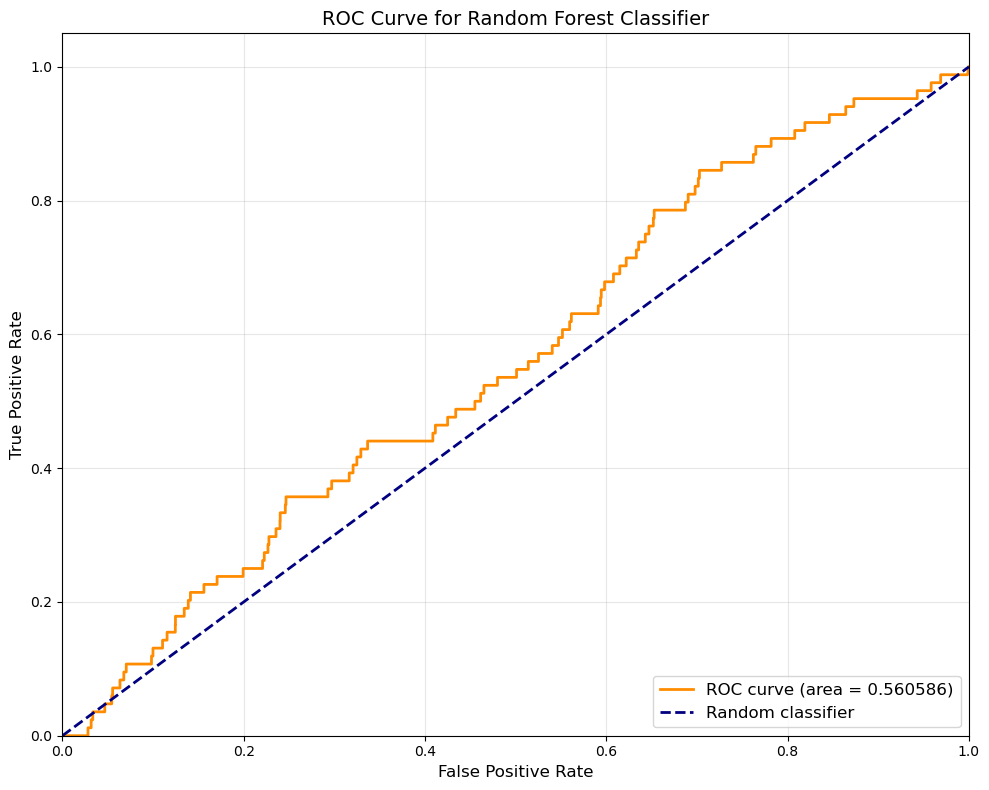

ROC AUC Score: 0.5606


In [34]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

print(f"Feature importances:\n", feature_importances.head())

# Generate the ROC curve
fpr, tpr, _ = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

# Create the plot
plt.figure(figsize=(10, 8))

# Plot ROC curve
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (area = {roc_auc:.6f})")

# Plot baseline
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--", label="Random classifier")

# Style the plot
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
plt.title("ROC Curve for Random Forest Classifier", fontsize=14)
plt.legend(loc="lower right", fontsize=12)

# Add grid
plt.grid(alpha=0.3)

# Display the plot
plt.tight_layout()
plt.show()

# Print numeric results for reference
print(f"ROC AUC Score: {roc_auc:.4f}")


5/20/25 - ROC area of .565: Downsampling approach, 20% test data, majority downsampled to make up 75% of data.
Length of y_pred : 335
Accuracy : .72

Conf matrix:
Accuracy: 0.7492537313432835
Precision: 0.0
Recall: 0.0

Features:
maj_landcover_code_y 0.027539
structure_code 0.010202
X_603 0.008226
X_2659 0.007409
X_3188 0.007161

rand_search scoring = precision


5/20/25 - ROC area of .99. Upsampled minority approach, 20% test data, minority upsampled to be 25% if total data. y_pred length: 17910, accuracy: .99
Conf matrix : Accuracy: 0.8551647124511446
Precision: 0.9989401165871754
Recall: 0.42104087558633013

Features: maj_landcover_code_y 0.012858
structure_code 0.005593
X_3007 0.002352
X_814 0.001987
X_2172 0.001817

rand_search scoring = precision
